In [1]:
# encoding: utf-8

In [2]:
import pandas as pd
import numpy as np

import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [3]:
try:
    h2o.cluster().shutdown()
except AttributeError:
    pass
    
h2o.init(nthreads = -1,
         max_mem_size = "24G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_171"; OpenJDK Runtime Environment (build 1.8.0_171-8u171-b11-0ubuntu0.16.04.1-b11); OpenJDK 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj0G_6U
  JVM stdout: /tmp/tmpj0G_6U/h2o_mourao_started_from_python.out
  JVM stderr: /tmp/tmpj0G_6U/h2o_mourao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Sao_Paulo
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,2 months and 23 days
H2O cluster name:,H2O_from_python_mourao_yvf0dn
H2O cluster total nodes:,1
H2O cluster free memory:,21.33 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [4]:
# seed for reproducibility
my_seed = 1980

In [5]:
my_path = '../data/'

In [6]:
# read data
train = h2o.import_file(my_path + 'c5_e3_1_train.csv')
train_us = h2o.import_file(my_path + 'c5_e3_1_train_under.csv')
train_os = h2o.import_file(my_path + 'c5_e3_1_train_over.csv')
test = h2o.import_file(my_path + 'c5_e3_1_test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# changing label to factor informs to H2O that the problem is solved by classification.
train['label'] = train['label'].asfactor()
train_us['label'] = train_us['label'].asfactor()
train_os['label'] = train_os['label'].asfactor()
test['label'] = test['label'].asfactor()

In [8]:
# list of features
features = train.columns
features.remove('label')

In [9]:
def check_sample(train, test, features, name):
    hyper_parameters = { 'alpha': [0, 0.1, 0.5, 0.7, 1.0] }

    lr_grid = H2OGridSearch(H2OGeneralizedLinearEstimator(family='binomial', 
                                                          seed=my_seed,
                                                          fold_assignment='Modulo',
                                                          lambda_search=True,
                                                          nfolds=5), 
                             grid_id=name,
                             hyper_params=hyper_parameters)

    lr_grid.train(x=features, 
                   y='label', 
                   training_frame=train)

    # Get the grid results, sorted by validation F1-Measure
    lr_gridperf1 = lr_grid.get_grid(sort_by='F1', decreasing=True)
    print(lr_gridperf1)

    # Grab the top LR model, chosen by validation F1
    best_lr1 = lr_gridperf1.models[0]

    # Now let's evaluate the model performance on a test set
    # so we get an honest estimate of top model performance
    best_lr_perf1 = best_lr1.model_performance(test)
    print(best_lr_perf1) 
    best_lr_perf1.plot()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
     alpha                     model_ids                  f1
0    [1.0]  Random Undersampling_model_4  0.8336908354655905
1    [0.0]  Random Undersampling_model_0   0.833674409086258
2    [0.1]  Random Undersampling_model_1  0.8336460335359704
3    [0.7]  Random Undersampling_model_3  0.8336395911750855
4    [0.5]  Random Undersampling_model_2  0.8335680070773022


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.139116113193
RMSE: 0.37298272506
LogLoss: 0.440309575441
Null degrees of freedom: 2852460
Residual degrees of freedom: 2852440
Null deviance: 4206774.19191
Residual deviance: 2511931.78374
AIC: 2511973.78374
AUC: 0.892211476038
Gini: 0.784422952076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.763769163125: 


,0,1,Error,Rate
0,2376269.0,180422.0,0.0706,(180422.0/2556691.0)
1,115626.0,180144.0,0.3909,(115626.0/295770.0)
Total,2491895.0,360566.0,0.1038,(296048.0/2852461.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7637692,0.5489383,81.0
max f2,0.5595585,0.6403228,145.0
max f0point5,0.8836668,0.5631339,42.0
max accuracy,0.9024617,0.9134281,36.0
max precision,0.9973179,0.9518878,0.0
max recall,0.0039819,1.0,399.0
max specificity,0.9973179,0.9999128,0.0
max absolute_mcc,0.7504149,0.4940981,85.0
max min_per_class_accuracy,0.5291523,0.8169862,155.0
max mean_per_class_accuracy,0.5183452,0.8174482,159.0


Gains/Lift Table: Avg response rate: 10,37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100001,0.9821048,7.8992733,7.8992733,0.8190710,0.8190710,0.0789938,0.0789938,689.9273274,689.9273274
,2,0.0200003,0.9668144,6.8613188,7.3802960,0.7114461,0.7652585,0.0686141,0.1476079,586.1318773,638.0296024
,3,0.0300001,0.9507530,6.2986099,7.0197424,0.6530991,0.7278730,0.0629848,0.2105927,529.8609863,601.9742397
,4,0.0400002,0.9336985,5.8777977,6.7342537,0.6094654,0.6982708,0.0587788,0.2693715,487.7797717,573.4253725
,5,0.0500003,0.9156843,5.3283918,6.4530794,0.5524978,0.6691160,0.0532846,0.3226561,432.8391833,545.3079375
,6,0.1000003,0.8169841,4.1576239,5.3053557,0.4311016,0.5501092,0.2078811,0.5305372,315.7623934,430.5355678
,7,0.1500003,0.7142143,2.7069692,4.4392289,0.2806840,0.4603010,0.1353484,0.6658857,170.6969201,343.9228877
,8,0.2000003,0.6152019,1.8020089,3.7799251,0.1868492,0.3919382,0.0901004,0.7559861,80.2008949,277.9925051
,9,0.3000002,0.4439582,1.0737063,2.8778532,0.1113320,0.2984029,0.1073706,0.8633567,7.3706297,187.7853187
,10,0.4000002,0.3139435,0.5665215,2.3000208,0.0587423,0.2384878,0.0566521,0.9200088,-43.3478518,130.0020767


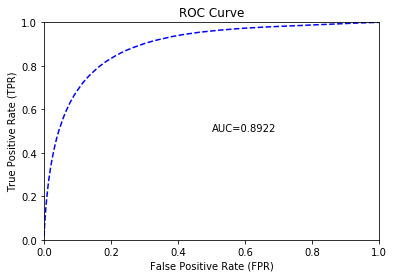

In [10]:
check_sample(train_us, test, features, 'Random Undersampling')

glm Grid Build progress: |████████████████████████████████████████████████| 100%
     alpha           model_ids                  f1
0    [0.0]  Unbalanced_model_0  0.5503097303216413
1    [0.1]  Unbalanced_model_1  0.5502888789339733
2    [0.5]  Unbalanced_model_2  0.5501785159126238
3    [0.7]  Unbalanced_model_3  0.5501306771164681
4    [1.0]  Unbalanced_model_4   0.550053714887086


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.0636081965864
RMSE: 0.252206654524
LogLoss: 0.217646059336
Null degrees of freedom: 2852460
Residual degrees of freedom: 2852440
Null deviance: 1900393.61728
Residual deviance: 1241653.79212
AIC: 1241695.79212
AUC: 0.891388099962
Gini: 0.782776199925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.255667489917: 


,0,1,Error,Rate
0,2379778.0,176913.0,0.0692,(176913.0/2556691.0)
1,116167.0,179603.0,0.3928,(116167.0/295770.0)
Total,2495945.0,356516.0,0.1027,(293080.0/2852461.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2556675,0.5506879,213.0
max f2,0.1249967,0.6397801,280.0
max f0point5,0.4374326,0.5696483,145.0
max accuracy,0.4821030,0.9144626,130.0
max precision,0.9926504,0.9895178,0.0
max recall,0.0007758,1.0,399.0
max specificity,0.9926504,0.9999980,0.0
max absolute_mcc,0.2496485,0.4959963,216.0
max min_per_class_accuracy,0.1067533,0.8159789,291.0
max mean_per_class_accuracy,0.1084473,0.8167143,290.0


Gains/Lift Table: Avg response rate: 10,37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100001,0.8289524,8.0372164,8.0372164,0.8333742,0.8333742,0.0803733,0.0803733,703.7216413,703.7216413
,2,0.0200003,0.7277561,7.0117715,7.5244939,0.7270465,0.7802103,0.0701187,0.1504919,601.1771462,652.4493937
,3,0.0300001,0.6461750,6.3875322,7.1455156,0.6623195,0.7409143,0.0638740,0.2143659,538.7532209,614.5515552
,4,0.0400002,0.5761137,5.9457550,6.8455728,0.6165118,0.7098134,0.0594584,0.2738243,494.5754999,584.5572785
,5,0.0500003,0.5162965,5.3581443,6.5480850,0.5555828,0.6789671,0.0535822,0.3274064,435.8144275,554.8084997
,6,0.1000003,0.3157384,4.1358503,5.3419719,0.4288439,0.5539059,0.2067924,0.5341989,313.5850251,434.1971853
,7,0.1500003,0.2083881,2.6507092,4.4448864,0.2748505,0.4608877,0.1325354,0.6667343,165.0709250,344.4886415
,8,0.2000003,0.1455156,1.7832782,3.7794855,0.1849071,0.3918926,0.0891639,0.7558982,78.3278172,277.9485521
,9,0.3000002,0.0792287,1.0605204,2.8731649,0.1099647,0.2979168,0.1060520,0.8619502,6.0520370,187.3164863
,10,0.4000002,0.0473754,0.5647634,2.2960650,0.0585600,0.2380776,0.0564763,0.9184265,-43.5236641,129.6064993


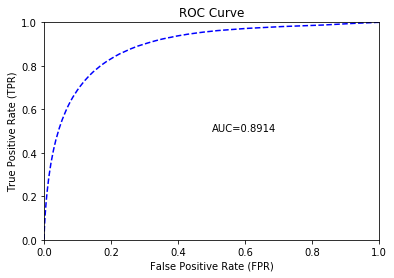

In [11]:
check_sample(train, test, features, 'Unbalanced')

glm Grid Build progress: |████████████████████████████████████████████████| 100%
     alpha                    model_ids                  f1
0    [0.7]  Random Oversampling_model_3   0.823249758264948
1    [0.1]  Random Oversampling_model_1  0.8232340008287502
2    [0.0]  Random Oversampling_model_0  0.8232184492761987
3    [0.5]  Random Oversampling_model_2  0.8231977791221452
4    [1.0]  Random Oversampling_model_4  0.8231966982051492


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.130863504969
RMSE: 0.361750611567
LogLoss: 0.41693671537
Null degrees of freedom: 2852460
Residual degrees of freedom: 2852442
Null deviance: 3954798.16686
Residual deviance: 2378591.44012
AIC: 2378629.44012
AUC: 0.892220116584
Gini: 0.784440233167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.745898451326: 


,0,1,Error,Rate
0,2378493.0,178198.0,0.0697,(178198.0/2556691.0)
1,116339.0,179431.0,0.3933,(116339.0/295770.0)
Total,2494832.0,357629.0,0.1033,(294537.0/2852461.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.7458985,0.5492234,84.0
max f2,0.5387191,0.6403749,151.0
max f0point5,0.8719422,0.5640755,45.0
max accuracy,0.8946845,0.9135354,36.0
max precision,0.9971937,0.9543717,0.0
max recall,0.0037281,1.0,399.0
max specificity,0.9971937,0.9999253,0.0
max absolute_mcc,0.7458985,0.4943333,84.0
max min_per_class_accuracy,0.5029685,0.8167258,164.0
max mean_per_class_accuracy,0.4969484,0.8174750,166.0


Gains/Lift Table: Avg response rate: 10,37 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100001,0.9798369,7.9060352,7.9060352,0.8197721,0.8197721,0.0790614,0.0790614,690.6035192,690.6035192
,2,0.0200003,0.9627156,6.8704474,7.3882413,0.7123926,0.7660824,0.0687054,0.1477668,587.0447363,638.8241278
,3,0.0300001,0.9448822,6.3013147,7.0259409,0.6533796,0.7285157,0.0630118,0.2107786,530.1314725,602.5940895
,4,0.0400002,0.9259759,5.8754310,6.7383109,0.6092200,0.6986915,0.0587551,0.2695338,487.5431046,573.8310912
,5,0.0500003,0.9062371,5.3463109,6.4599090,0.5543558,0.6698242,0.0534638,0.3229976,434.6310918,545.9908961
,6,0.1000003,0.7997241,4.1560011,5.3079590,0.4309333,0.5503791,0.2078000,0.5307976,315.6001051,430.7959044
,7,0.1500003,0.6913594,2.7056844,4.4405362,0.2805508,0.4604366,0.1352842,0.6660818,170.5684419,344.0536197
,8,0.2000003,0.5893776,1.8026852,3.7810746,0.1869194,0.3920574,0.0901342,0.7562160,80.2685150,278.1074591
,9,0.3000002,0.4181331,1.0717791,2.8779772,0.1111321,0.2984158,0.1071779,0.8633939,7.1779123,187.7977157
,10,0.4000002,0.2921222,0.5647972,2.2996827,0.0585635,0.2384527,0.0564797,0.9198736,-43.5202831,129.9682667


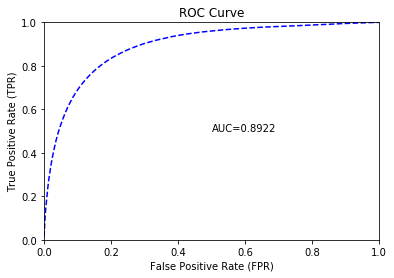

In [12]:
check_sample(train_os, test, features, 'Random Oversampling')

In [ ]:
train_us = pd.read_csv(my_path + 'c5_e3_1_train_under.csv')
test = pd.read_csv(my_path + 'c5_e3_1_test.csv')

In [ ]:
features = [ x for x in train_us.columns if x != 'label']

In [ ]:
# create libsvm files inspired in https://github.com/zygmuntz/phraug

def create_libsvm(df, features, out):

    with open(out, 'w') as w:
        for index, row in df.iterrows():
            new_row = str(int(row['label']))
            for i, col in enumerate(features):
                new_row += ' %s:%s' % (i + 1, str(row[col]))
            w.write(new_row + '\n')

In [ ]:
create_libsvm(train_us, features, my_path + 'c5_e4_1_train.svm')
create_libsvm(test, features, my_path + 'c5_e4_1_test.svm')